# Category Embedding

### We joined the Elo multi-target competition on Kaggle.

A few words about the competition:
Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.

Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. 

In this competition, we are expected to develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.

In [1]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import l2
from keras.optimizers import *
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 
import xgboost as xgb

Using TensorFlow backend.


## Data Analysis:

Lets load the given data in order to understand the different attrivutes and the data shape.

In [2]:
train = pd.read_csv("../input/train.csv")
print("shape of train : ",train.shape)

shape of train :  (201917, 6)


In [3]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [4]:
test = pd.read_csv("../input/test.csv")
print("shape of test : ",test.shape)



shape of test :  (123623, 5)


In [5]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [6]:
merchants = pd.read_csv("../input/merchants.csv")
print("shape of merchants : ",merchants.shape)
merchants.head()


shape of merchants :  (334696, 22)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [7]:
historical_transactions = pd.read_csv("../input/historical_transactions.csv")
historical_transactions.drop(['authorized_flag','category_1','installments','category_3','category_2','state_id','subsector_id','city_id'],axis = 1, inplace = True)
print("shape of merchants : ",historical_transactions.shape)
historical_transactions.head()

shape of merchants :  (29112361, 6)


,card_id,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,C_ID_4e6213e9bc,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07
1,C_ID_4e6213e9bc,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45
2,C_ID_4e6213e9bc,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29
3,C_ID_4e6213e9bc,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26
4,C_ID_4e6213e9bc,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19


In [8]:
new_merchant_transactions = pd.read_csv("../input/new_merchant_transactions.csv")
print("shape of merchants : ",new_merchant_transactions.shape)
new_merchant_transactions.head()

shape of merchants :  (1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [9]:
cardCountTrain = train['card_id'].unique().size
print(cardCountTrain)
print(train['card_id'].size)
cardCountTest = test['card_id'].unique().size
print(cardCountTest)
print(test['card_id'].size)

201917
201917
123623
123623


Every value of card_id attribute in Train and Test is unique.

In [10]:
cardCountTransactions = historical_transactions['card_id'].unique().size
print(cardCountTransactions)


325540


We see that: cardCountTrain + cardCountTest = cardCountTransactions,

Lets try to join the dataframes to get all the values.

Lets also see the correlation of the features 1,2,3 with the target.

In [11]:
import seaborn as sns 

C:\Users\igor8\Anaconda3\envs\deep learning\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


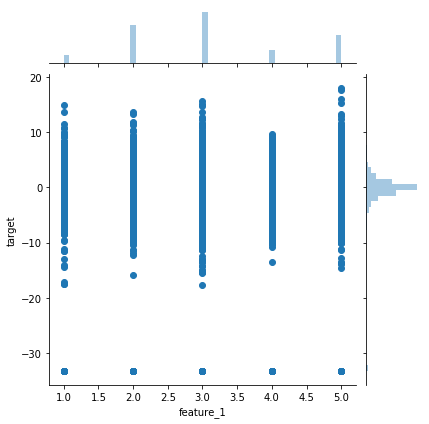

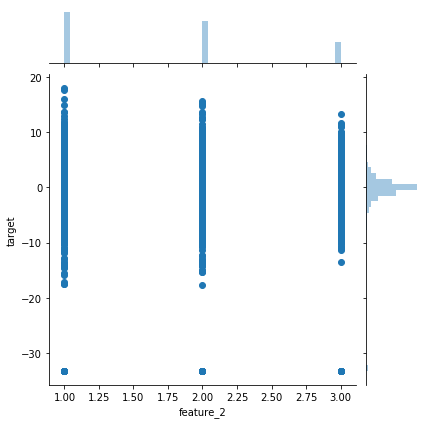

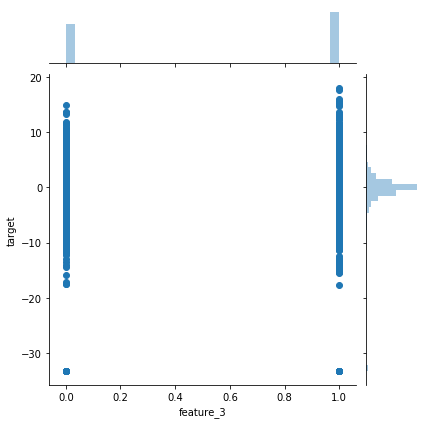

In [12]:
sns.jointplot(x=train['feature_1'], y=train['target'], data=train)  
plt.show()

sns.jointplot(x=train['feature_2'], y=train['target'], data=train)  
plt.show()

sns.jointplot(x=train['feature_3'], y=train['target'], data=train)  
plt.show()

We see that features 1,2,3 distribute uniformly. There is a small amount of possible values for each feature. We would like to get more insights by joining the historical_transactions and train. 

In [13]:
print('unique merchant_id : {0}'.format(historical_transactions['merchant_id'].nunique()))
print('unique merchant_category_id : {0}'.format(historical_transactions['merchant_category_id'].nunique()))
print('unique month_lag : {0}'.format(historical_transactions['month_lag'].nunique()))
print('unique purchase_date : {0}'.format(historical_transactions['purchase_date'].nunique()))
print('unique purchase_amount : {0}'.format(historical_transactions['purchase_amount'].nunique()))

unique merchant_id : 326311
unique merchant_category_id : 327
unique month_lag : 14
unique purchase_date : 16395300
unique purchase_amount : 215014


## Starting to preproccess the data:

Lets look at some features from other datasets. We can merge the transactions dataset with the train to see how other features correlate with target.


In [43]:
joinedTrain = pd.merge(train, historical_transactions, on = 'card_id',how='inner')


In [44]:
joinedTrain.head(30)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11
1,2017-06,C_ID_92a2005557,5,2,1,-0.820283,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00
2,2017-06,C_ID_92a2005557,5,2,1,-0.820283,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16
3,2017-06,C_ID_92a2005557,5,2,1,-0.820283,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58
4,2017-06,C_ID_92a2005557,5,2,1,-0.820283,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18
5,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_b3c49066d8,-6,-0.662158,2017-08-13 13:43:07
6,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_b3c49066d8,-1,-0.665614,2018-01-27 06:44:29
7,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_b3c49066d8,-7,-0.727944,2017-07-01 09:02:20
8,2017-06,C_ID_92a2005557,5,2,1,-0.820283,80,M_ID_c124c4467a,-5,-0.620986,2017-09-02 23:05:56
9,2017-06,C_ID_92a2005557,5,2,1,-0.820283,560,M_ID_1a81c358a3,-7,-0.722114,2017-07-27 08:17:48


In [45]:
joinedTrain.dropna(inplace=True)
joinedTrain.shape


(17943982, 11)

In [46]:
Train2 = joinedTrain

In [47]:
Train2.shape

(17943982, 11)

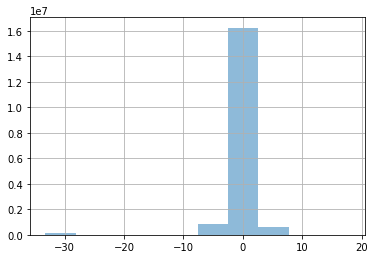

In [48]:
joinedTrain['target'].hist(alpha=0.5)

In [49]:
joinedTrain = joinedTrain.sample(2500000)
joinedTrain.shape

(2500000, 11)

In [50]:
joinedTest = pd.merge(test, historical_transactions, on = 'card_id',how='inner')
joinedTest.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,2017-04,C_ID_0ab67a22ab,3,3,1,412,M_ID_85a5803161,-8,-0.697320,2017-04-27 14:17:27
1,2017-04,C_ID_0ab67a22ab,3,3,1,278,M_ID_c873d839bd,-3,-0.716855,2017-09-21 22:11:57
2,2017-04,C_ID_0ab67a22ab,3,3,1,879,M_ID_9139332ccc,-6,-0.480082,2017-06-22 22:53:59
3,2017-04,C_ID_0ab67a22ab,3,3,1,80,M_ID_26c089d552,-8,-0.743902,2017-04-04 18:22:24
4,2017-04,C_ID_0ab67a22ab,3,3,1,278,M_ID_26c089d552,-2,-0.711595,2017-10-06 23:51:21


In [51]:
joinedTest.dropna(inplace=True)
joinedTest.shape

(11029843, 10)

In [52]:
from sklearn import preprocessing

target = joinedTrain['target'].values
min_max_scaler = preprocessing.MinMaxScaler()
normalizedTarget = min_max_scaler.fit_transform(target.reshape(-1, 1))

In [53]:
min_max_scaler.inverse_transform(normalizedTarget.reshape(1,-1))


array([[-0.32828987, -0.62068216, -1.38703815, ..., -0.5122897 ,
        -0.80141056,  1.82058434]])

## Starting to create the embeddings:

We create an embedding with depth of 5 for each feature in the present data. 

In [54]:
first_active_month = {p:i for (i,p) in enumerate(joinedTrain['first_active_month'].unique())}
card_id = {p:i for (i,p) in enumerate(joinedTrain['card_id'].unique())}
feature_1 = {p:i for (i,p) in enumerate(joinedTrain['feature_1'].unique())}
feature_2 = {p:i for (i,p) in enumerate(joinedTrain['feature_2'].unique())}
feature_3 = {p:i for (i,p) in enumerate(joinedTrain['feature_3'].unique())}
merchant_category_id = {p:i for (i,p) in enumerate(joinedTrain['merchant_category_id'].unique())}
merchant_id = {p:i for (i,p) in enumerate(joinedTrain['merchant_id'].unique())}
month_lag = {p:i for (i,p) in enumerate(joinedTrain['month_lag'].unique())}
purchase_amount = {p:i for (i,p) in enumerate(joinedTrain['purchase_amount'].unique())}
purchase_date = {p:i for (i,p) in enumerate(joinedTrain['purchase_date'].unique())}


In [55]:
processed_data = joinedTrain.loc[:,['first_active_month','card_id','feature_1','feature_2',
                                    'feature_3','merchant_category_id','merchant_id','month_lag',
                                   'purchase_amount','purchase_date']].copy()
processed_data['first_active_month'] = [first_active_month[x] for x in joinedTrain['first_active_month']]
processed_data['card_id'] = [card_id[x] for x in joinedTrain['card_id']]
processed_data['feature_1'] = [feature_1[x] for x in joinedTrain['feature_1']]
processed_data['feature_2'] = [feature_2[x] for x in joinedTrain['feature_2']]
processed_data['feature_3'] = [feature_3[x] for x in joinedTrain['feature_3']]
processed_data['merchant_category_id'] = [merchant_category_id[x] for x in joinedTrain['merchant_category_id']]
processed_data['merchant_id'] = [merchant_id[x] for x in joinedTrain['merchant_id']]
processed_data['month_lag'] = [month_lag[x] for x in joinedTrain['month_lag']]
processed_data['purchase_amount'] = [purchase_amount[x] for x in joinedTrain['purchase_amount']]
processed_data['purchase_date'] = [purchase_date[x] for x in joinedTrain['purchase_date']]


In [56]:
first_active_inp = Input(shape=(1,),dtype='int64')
card_inp = Input(shape=(1,),dtype='int64')
f1_inp = Input(shape=(1,),dtype='int64')
f2_inp = Input(shape=(1,),dtype='int64')
f3_inp = Input(shape=(1,),dtype='int64')
mcid_inp = Input(shape=(1,),dtype='int64')
mid_inp = Input(shape=(1,),dtype='int64')
month_lag_inp = Input(shape=(1,),dtype='int64')
p_amount_inp = Input(shape=(1,),dtype='int64')
p_date_inp = Input(shape=(1,),dtype='int64')

first_active_emb = Embedding(len(first_active_month),5,input_length=1)(first_active_inp)
card_emb = Embedding(len(card_id),5,input_length=1)(card_inp)
f1_emb = Embedding(len(feature_1),5,input_length=1)(f1_inp)
f2_emb = Embedding(len(feature_2),5,input_length=1)(f2_inp)
f3_emb = Embedding(len(feature_3),5,input_length=1)(f3_inp)
mcid_emb = Embedding(len(merchant_category_id),5,input_length=1)(mcid_inp)
mid_emb = Embedding(len(merchant_id),5,input_length=1)(mid_inp)
month_lag_emb = Embedding(len(month_lag),5,input_length=1)(month_lag_inp)
p_amount_emb = Embedding(len(purchase_amount),5,input_length=1)(p_amount_inp)
p_date_emb = Embedding(len(purchase_date),5,input_length=1)(p_date_inp)

In [57]:
print(mid_inp)

Tensor("input_17:0", shape=(?, 1), dtype=int64)


## Building the model:

In [58]:
x = concatenate([first_active_emb,card_emb,f1_emb,f2_emb,f3_emb,mcid_emb,mid_emb,month_lag_emb,p_amount_emb,p_date_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(5,activation='relu')(x)
x = Dense(1)(x)
nn_model = Model([first_active_inp,card_inp,f1_inp,f2_inp,f3_inp,mcid_inp,mid_inp,month_lag_inp,p_amount_inp,p_date_inp],x)
nn_model.compile(loss = 'mse',optimizer='adam')

In [59]:
nn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_15 (

In [60]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split

def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp = ModelCheckpoint('best_model_weights_{}.h5'.format(description),save_best_only=True)
    rlop = ReduceLROnPlateau(patience=5)   
    cb = [cp,rlop]
    return cb

features = processed_data.columns
X_train,X_val,y_train,y_val = train_test_split(processed_data, normalizedTarget, test_size=0.2)


In [61]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(2000000, 10)
(500000, 10)
(2000000, 1)
(500000, 1)


In [62]:

min_max_scaler.inverse_transform(y_val.reshape(1,-1))


array([[-0.42802984, -0.66012294, -0.55930772, ..., -0.30597486,
        -1.12734596, -1.39728825]])

## Fitting the model:

In [63]:
history = nn_model.fit([X_train[f] for f in features],y_train,epochs=5, batch_size=2000,
             validation_data=[[X_val[f] for f in features],y_val],callbacks=set_callbacks())


Train on 2000000 samples, validate on 500000 samples
Epoch 1/5
2000000/2000000 [==============================] - 366s 183us/step - loss: 0.0198 - val_loss: 0.0038
Epoch 2/5
2000000/2000000 [==============================] - 357s 178us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/5
2000000/2000000 [==============================] - 358s 179us/step - loss: 7.5115e-04 - val_loss: 5.3909e-04
Epoch 4/5
2000000/2000000 [==============================] - 369s 185us/step - loss: 3.5529e-04 - val_loss: 3.9618e-04
Epoch 5/5
2000000/2000000 [==============================] - 323s 162us/step - loss: 2.3539e-04 - val_loss: 2.5816e-04


## Looking at the results we got:

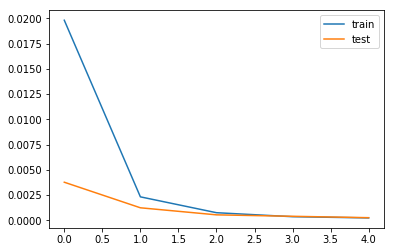

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [65]:
nn_model.load_weights('./best_model_weights_run1.h5')
preds = nn_model.predict([X_val[f] for f in features])


(array([1.52100e+03, 2.79300e+03, 2.82000e+02, 1.67000e+02, 8.70000e+01,
        6.90000e+01, 3.20000e+01, 1.40000e+01, 1.20000e+01, 9.00000e+00,
        8.00000e+00, 1.80000e+01, 2.70000e+01, 2.10000e+01, 4.60000e+01,
        1.30000e+02, 3.12000e+02, 6.90000e+02, 2.42600e+03, 7.22900e+03,
        3.07230e+04, 1.49272e+05, 2.36769e+05, 5.49110e+04, 9.91800e+03,
        1.80900e+03, 5.76000e+02, 1.03000e+02, 2.30000e+01, 3.00000e+00]),
 array([-0.02082828,  0.00920235,  0.03923297,  0.06926359,  0.09929422,
         0.12932484,  0.15935546,  0.18938608,  0.21941671,  0.24944733,
         0.27947795,  0.30950856,  0.3395392 ,  0.36956984,  0.39960045,
         0.42963105,  0.4596617 ,  0.48969233,  0.51972294,  0.54975355,
         0.57978415,  0.6098148 ,  0.63984543,  0.66987604,  0.6999067 ,
         0.7299373 ,  0.7599679 ,  0.78999853,  0.82002914,  0.8500598 ,
         0.8800904 ], dtype=float32),
 <a list of 30 Patch objects>)

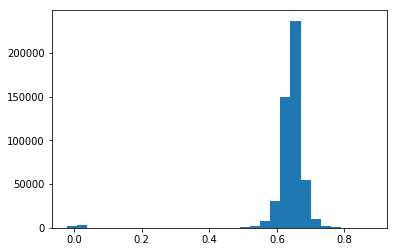

In [66]:
plt.hist(preds,bins=30)

In [67]:
predsDF = pd.DataFrame(data = preds)
testDF = pd.DataFrame(data = y_val)

In [68]:
min_max_scaler.inverse_transform(y_val.reshape(1,-1))


array([[-0.42802984, -0.66012294, -0.55930772, ..., -0.30597486,
        -1.12734596, -1.39728825]])

In [69]:
min_max_scaler.inverse_transform(preds.reshape(1,-1))


array([[-0.72607917, -0.02739147, -1.234008  , ...,  0.06637869,
        -1.558808  , -1.1836693 ]], dtype=float32)

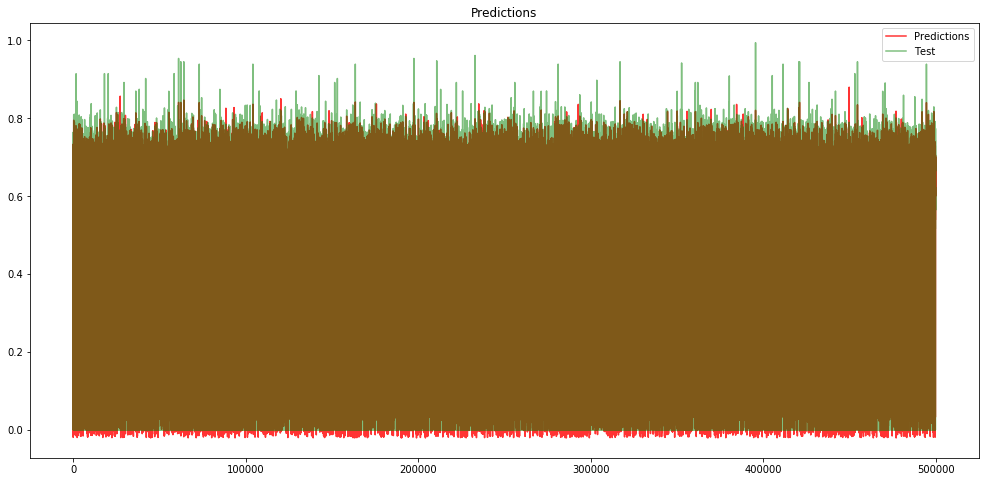

In [70]:
plt.figure(figsize=(17,8))
plt.plot(predsDF,c='red',alpha=0.8,label='Predictions')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.title('Predictions')
plt.legend()

In [71]:
from sklearn.metrics import r2_score 

print('The score of model is:')
print(r2_score(testDF.values,predsDF.values))

The score of model is:
0.949241591067164


In [90]:
joinedTrain.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
4979401,2017-11,C_ID_580e90af8c,3,3,1,-0.328290,307,M_ID_5d17b5fc5a,-2,-0.721363,2017-12-12 12:18:29
30092,2014-04,C_ID_8ea5a45854,3,3,1,-0.620682,19,M_ID_7c66f8cb5a,-1,-0.429202,2018-01-31 16:40:56
7776058,2017-01,C_ID_347651e6ff,1,1,0,-1.387038,667,M_ID_e4e431eabd,-1,-0.599648,2018-01-29 15:00:46
16589835,2017-02,C_ID_0237075e28,3,1,1,1.247327,518,M_ID_dadc1d352a,-10,-0.697921,2017-04-22 10:06:07
11426272,2017-10,C_ID_44c36b5169,3,2,1,-1.628844,879,M_ID_00a6ca8a8a,-4,-0.671775,2017-10-17 18:12:15


In [91]:
joinedTest.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date
0,2017-04,C_ID_0ab67a22ab,3,3,1,412,M_ID_85a5803161,-8,-0.697320,2017-04-27 14:17:27
1,2017-04,C_ID_0ab67a22ab,3,3,1,278,M_ID_c873d839bd,-3,-0.716855,2017-09-21 22:11:57
2,2017-04,C_ID_0ab67a22ab,3,3,1,879,M_ID_9139332ccc,-6,-0.480082,2017-06-22 22:53:59
3,2017-04,C_ID_0ab67a22ab,3,3,1,80,M_ID_26c089d552,-8,-0.743902,2017-04-04 18:22:24
4,2017-04,C_ID_0ab67a22ab,3,3,1,278,M_ID_26c089d552,-2,-0.711595,2017-10-06 23:51:21


In [89]:
testPreds = nn_model.predict([joinedTest[f] for f in features])


ValueError: invalid literal for int() with base 10: '2017-04'

## ML Benchmark:

In [ ]:
from sklearn.linear_model import LinearRegression

mlTrain = train.drop('target', axis = 1)
mlTrain = mlTrain.drop('first_active_month', axis = 1)
mlTarget = train['target']
lm = LinearRegression()
#lm.fit(mlTrain,mlTarget)

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=42)
# kf = KFold(n_splits=5,random_state=42)
for tr_ind,val_ind in kf.split(processed_data,target):
    X_train,X_val,y_train,y_val = processed_data.iloc[tr_ind],processed_data.iloc[val_ind],target[tr_ind],target[val_ind]
    nn_model.fit([X_train[f] for f in features],to_categorical(y_train),epochs=25,
                 validation_data=[[X_val[f] for f in features],to_categorical(y_val)],callbacks=set_callbacks())
    break